In [141]:
# Ours
from py_files.characters_real_names import *

# Modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from community import community_louvain as louvain
from netwulf import visualize

import re

import time
import math
import random
import statistics

# ---
# Spacy setup
# python -m spacy download en

import spacy

from spacy.tokens import Span
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

# Used to get the gender and distinct people with same family noun. 

def get_person_title(span):
    if span.label_ == "PERSON" and span.start != 0:
        prev_token = span.doc[span.start - 1]
        if prev_token.text in ("Mr", "Mr.", "Mrs", "Mrs."):
            return prev_token.text + " "
    return ""
            

Span.set_extension("person_title", getter=get_person_title, force=True)

# ---
# Get the book text data

book = open("./Harry Potter and the Sorcerer.txt").read()

book_chapters = re.split(r'CHAPTER [\w+]+', book, flags=re.IGNORECASE)[1:]
book_chapters[-1] = book_chapters[-1].split("THE END")[0]

# displacy.serve(nlp(book), style="ent")

In [3]:
# ---
# Cleaning and tokenization

book_chapters_paragraphs = dict()
real_charachers_by_paragraphs = list()

for i, chapter in enumerate(book_chapters):

    # Split and clean up each paragraphs
    paragraphs = chapter.split('\n\n')
    
    for paragraph in paragraphs:
        clean_paragraph = re.sub(r"[\"\;\:\s]+", ' ', paragraph)

        # Tag and detect every person's name by paragraph
        tokens = nlp(clean_paragraph)
        paragraph_persons = [(ent._.person_title + ent.text) for ent in tokens.ents if ent.label_ == "PERSON"]

        # Correct all possible mentions of a person
        # And remove false positive

        real_paragraph_persons = []
        for person in paragraph_persons:
            if person in persons_real_names: real_paragraph_persons.append(person)
            else: 
                for check, replace in name_to_replace.items():
                    reg = re.compile(check, )
                    if reg.match(person): 
                        real_paragraph_persons.append(replace)
                        break
        
        real_charachers_by_paragraphs.append(set(real_paragraph_persons))
        

    book_chapters_paragraphs[i] = paragraphs

In [80]:
# ---
# Graph Filling
# Add edge between 2 characters of the same paragraph
graph = nx.Graph()

for unique_paragraph_persons in real_charachers_by_paragraphs: 
    if len(unique_paragraph_persons) < 2 : continue
    graph.add_nodes_from(unique_paragraph_persons)
    unique = list(unique_paragraph_persons)
    for idx in range(len(unique)-1):
        edge = graph.get_edge_data(unique[idx], unique[idx-1])
        if edge is not None : graph[unique[idx]][unique[idx-1]]['weight'] += 1
        else : graph.add_edge(unique[idx], unique[idx-1], weight=1)

# Useful 
list_edges = list(graph.edges())
list_nodes = list(graph.nodes())

edges_weight = np.array([graph[u][v].get('weight', 1) for u, v in list_edges])
nodes_size = np.array([len(list(graph.neighbors(node))) for node in list_nodes])

In [150]:
print(min(edges_weight), max(edges_weight), statistics.mean(edges_weight), statistics.median(edges_weight), statistics.stdev(edges_weight))


1 172 4 1 13.490737563232042


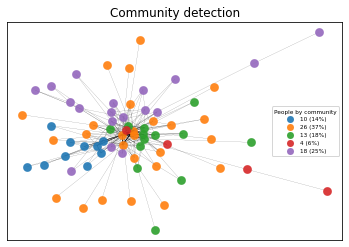

In [329]:
# ---
# Louvain Algorithm
# https://github.com/taynaud/python-louvain

# Use mean partition of 100 partitions to smooth
boot_partitions = {}
for _ in range(100): 
    part = louvain.best_partition(graph)
    for k,v in part.items():
        if k in boot_partitions: boot_partitions[k].append(v)
        else: boot_partitions[k] = [v]

partition = {}
for k,v in boot_partitions.items(): partition[k] = round(sum(v) / len(v))

# Get the position of nodes and the colors
seed = 2
pos = nx.spring_layout(graph, seed=seed)
custom_width = [max((w/30,w/100)[w > 30], 0.1) for w in edges_weight]
#custom_colors = ["#FF3333", "#4CA64C", "#3333FF", "#00B4D8", "#E36414", "#621D9A"]
custom_colors = ["#FF595E", "#FFCA3A", "#8AC926", "#1982C4", "#6A4C93"]

# Transform names to integer for a better readability
most_neighbors = {}
int_names = {}
threshold = 90
for i,n in enumerate(partition): 
    index = len(int_names)+1
    int_names[n] = index
    if nodes_size[i] >= np.percentile(nodes_size, threshold): most_neighbors[n] = index

for i in range(max(partition.values()) + 1):
    pp = len([1 for k,v in partition.items() if v == i])
    pc = 100*pp/len(partition)
    lab = f"{pp} ({round(pc)}%)"
    nx.draw_networkx_nodes(graph, pos, nodelist=[k for k,v in partition.items() if v == i], node_color=partition.get(i), linewidths=0.1, node_shape=".", alpha=0.9, label=lab)

nx.draw_networkx_edges(graph, pos, width=custom_width)
#nx.draw_networkx_labels(graph, pos, font_size=3.5) # Replace int_names by most_neighbors to only display same as the legend 
plt.legend(fontsize='xx-small',title_fontsize="xx-small", markerscale=0.8, title=f"People by community")
plt.title("Community detection")
plt.savefig(f"../miscellaneous/plot/louvain-spring-people-nolabel.jpg", format="jpg", dpi=1000)
plt.show()


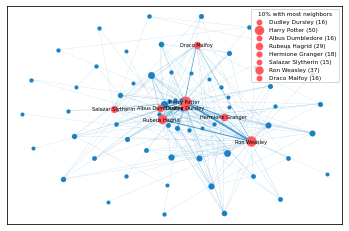

In [333]:
pos = nx.layout.circular_layout(graph)
# Draw the graph
for i,no in enumerate(graph.nodes()):
    lab = ("_", f"{no} ({len(list(graph.neighbors(no)))})")[no in most_neighbors.keys()]
    nx.draw_networkx_nodes(graph, pos, nodelist=[no], node_size=nodes_size[i]*10+50,node_color=custom_colors[(3,0)[lab != "_"]], linewidths=0.1, node_shape=".", label=lab)

nx.draw_networkx_edges(graph, pos, width=custom_width, edge_color=custom_colors[3], alpha=0.8)
nx.draw_networkx_labels(graph, pos, labels={k:k for k in most_neighbors.keys()}, font_size=5) # Replace int_names by most_neighbors to only display same as the legend 
plt.legend(fontsize='xx-small',title_fontsize="xx-small", markerscale=0.8, title=f"{100-threshold}% with most neighbors")
plt.savefig(f"../miscellaneous/plot/graph-10-most.jpg", format="jpg", dpi=1000)
plt.show()


In [97]:
# ---
# K-Core decomposition

def kcore(graph):

    knots, decomposition = {}, {}

    # Using a dictionary
    for person in graph.nodes:
        neighbors = list(graph.neighbors(person))
        knots[person] = {"neighbors": neighbors, "degree": len(neighbors), "pruned": False}

    k, total_pruned = 1, 0

    while total_pruned < len(graph):
        to_prune = [person for person,elems in knots.items() if elems['degree'] == k]
        k_shell = []
        while len(to_prune) > 0:
            x = to_prune.pop(0)
            for n in knots.get(x)['neighbors']:
                v = knots.get(n)
                if not v['pruned']:
                    v['degree'] -= 1
                    if v['degree'] == k : to_prune.append(n)
            knots.get(x)['pruned'] = True
            k_shell.append(x)
            total_pruned += 1
        decomposition[k] = k_shell
        k += 1
    
    return decomposition 

def kcore_order(graph,order):

    new_graph = graph.copy()
    output = kcore(new_graph)
    for i in range(order-1): new_graph.remove_nodes_from(output[i+1])
    return new_graph


def barabasi_albert_generate_graph(graph):
    nb_nodes = len(graph.nodes())
    mean_number_of_edges = round(graph.number_of_edges() / nb_nodes)
    return nx.barabasi_albert_graph(nb_nodes, mean_number_of_edges)

kcore_output = kcore(graph)

# bgraph = gen_barabazi(graph)
# new_graph = order_kcore(bgraph,2)
                

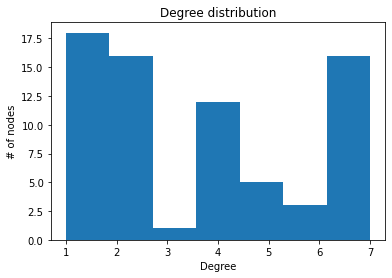

In [155]:
# --- 
# Draw an histogram of the nodes' degree

kcore_hist = [int(k) for k in kcore_output.keys() for _ in range(len(kcore_output.get(k)))]
plt.title("Degree distribution")
plt.xlabel("Degree")
plt.ylabel("# of nodes")
plt.hist(kcore_hist, bins=len(kcore_output.keys()))
plt.savefig("../miscellaneous/plot/degree-distribution.pdf", format="pdf", dpi=1000)

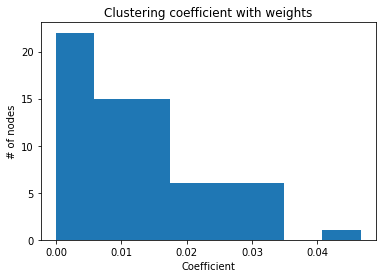

In [154]:
# Draw histogram of clustering coefficient

clust_coeffs_weight = list(nx.clustering(graph, weight="weight").values())
clust_coeffs = list(nx.clustering(graph).values())

# Same formula as in the slides
plt.hist(clust_coeffs, bins="auto")
plt.ylabel("# of nodes")
plt.xlabel("Coefficient")
plt.title("Clustering coefficient")
plt.savefig("../miscellaneous/plot/clustering-coef.pdf", format="pdf", dpi=1000)

plt.clf()

# See docs
plt.hist(clust_coeffs_weight, bins="auto")
plt.title("Clustering coefficient with weights")
plt.ylabel("# of nodes")
plt.xlabel("Coefficient")
plt.savefig("../miscellaneous/plot/clustering-coef-weight.pdf", format="pdf", dpi=1000)

In [98]:
# ---
# Greedy Implementation of the Influence Maximization Problem
# Reworked version

def generate_active_edges(graph:nx.Graph, p:float) -> nx.Graph:

    g = graph.copy()
    edges = list(g.edges)
    # As the instruction does not specify what percentage of activated edges we have to take, we have chosen to use multinomial experiments.
    # But we left the possibility to enforce a certain percentage of activated edges as well.
    if p is not None and p > 0:
        edges_mapped = {i:n for i,n in enumerate(g.edges.keys())}
        activated_edges = random.choices(range(len(edges)), edges_weight, k = round(len(edges)*p))
        for activated in activated_edges: 
            u,v = edges_mapped.get(activated) 
            g[u][v]['activated'] = True
    else:
        edges_proba = edges_weight/sum(edges_weight)
        activated_edges = np.random.multinomial(len(edges), edges_proba)
        activated_edges = activated_edges > 0
        for activated, (u, v, info) in zip(activated_edges, g.edges.data()): g[u][v]['activated'] = activated
        print(sum(activated_edges)/len(edges))
    return g

def get_accessible_neighbors(g:nx.Graph, node) -> list:
    accessible_neighbors = []
    for neighbor in g.neighbors(node):
        if g[node][neighbor].get('activated', False):
            accessible_neighbors.append(neighbor)
    
    return accessible_neighbors

def get_number_accessible_neighbors(g:nx.Graph, A0:list) -> dict:
    neighbors = A0[:]
    new_neighbors = A0[:]
    while new_neighbors:
        node = new_neighbors.pop()
        new_neighbors += get_accessible_neighbors(g, node)
        new_neighbors = list(set(new_neighbors) - set(neighbors))
        neighbors += new_neighbors

    return dict(count=len(neighbors),accessible_neighbors=neighbors)

def greedy(graph:nx.Graph, k:int, n:int, p = 0) -> list:
    A0 = []
    graphs = [generate_active_edges(graph, p) for _ in range(n)]

    for _ in range(k):
        nodes_to_test = list(set(graph.nodes) - set(A0))
        nodes_score = dict(zip(nodes_to_test, [0]*len(nodes_to_test)))
        for node in nodes_to_test:
            for g in graphs:
                accessible_dict = get_number_accessible_neighbors(g, A0+[node])
                nodes_score[node] += accessible_dict.get('count')

        # Retrieve the max
        best_node = max(nodes_score, key=nodes_score.get)
        A0.append(best_node)

    return A0



Best 4 nodes with 710 simulations : ['Harry Potter', 'Ron Weasley', 'Rubeus Hagrid', 'Dudley Dursley']


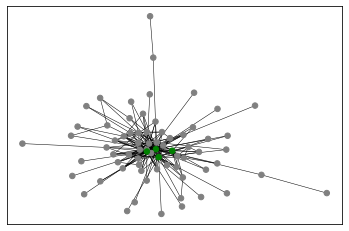

In [99]:
k = round(graph.number_of_nodes() * 0.05)
n = len(graph.nodes()) * 10
p = 0.1

A0 = greedy(graph, k, n, p)

print(f"Best {k} nodes with {n} simulations : {A0}")

node_colors = ["green" if no in A0 else "gray" for no in graph.nodes]
nx.draw_networkx(graph, node_color=node_colors, node_size=30, labels=int_names, with_labels=False, width=0.5)

In [95]:
# ---
# Independant Cascade Model
# Reworked version

def independant_cascade_model(graph, active_nodes, p):

    g = graph.copy()

    already_active = set(active_nodes[:])
    to_propagate = active_nodes[:]

    while to_propagate:
        active = to_propagate.pop()
        neighbors = list(g.neighbors(active))
        tried = []
        for nei in neighbors:
            if nei in already_active: continue
            activation = random.random() < p
            if activation: 
                g[active][nei]['activated'] = True
                to_propagate.append(nei)
                already_active.add(nei)
            else:
                g[active][nei]['tried'] = True

    # edges_color = ["blue" if g[u][v].get('activated', False) else "black" if g[u][v].get('tried', False) else "gray" for u, v in g.edges]
    # nodes_color = ["green" if no in active_nodes else "blue" if no in already_active else "gray" for no in g.nodes]

    # nx.draw_networkx(g, edge_color=edges_color, node_color=nodes_color, node_size=35, width=0.25, with_labels=False)
    # plt.show()

    spread = len(already_active)
    return {'spread': spread, 'list_active': already_active}


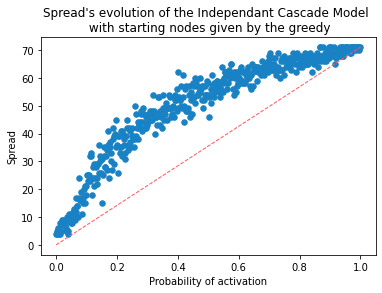

In [181]:
# Mean spread of cascade model 
all_spread_cascade = []
X = np.arange(0,1,1/500)

for p in X:
    spread,_ = independant_cascade_model(graph, A0, p).values()
    all_spread_cascade.append(spread)


fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(X, all_spread_cascade, s=30, c=custom_colors[3])
plt.title("Spread's evolution of the Independant Cascade Model \n with starting nodes given by the greedy")
plt.xlabel("Probability of activation")
plt.ylabel("Spread")
ax.plot([0,1], [0,71], c=custom_colors[0], linestyle="dashed", linewidth=1)
plt.savefig("../miscellaneous/plot/cascade-model-by-probability.pdf", format="pdf", dpi=1000)